This model is mainly about classificate if the images are open or close

In [2]:
!pip install tensorflow==2.16.1

  Using cached tensorflow-2.16.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Using cached ml_dtypes-0.3.2-cp312-cp312-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.16.1-cp312-cp312-macosx_12_0_arm64.whl (227.1 MB)
Using cached ml_dtypes-0.3.2-cp312-cp312-macosx_10_9_universal2.whl (393 kB)
Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0

[notice] A new release of pip is avai

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [7]:
# Generate data paths with labels
data_dir = 'data/train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)

    # jump os files
    if not os.path.isdir(foldpath):
        continue

    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [8]:
df

,filepaths,labels
0,data/train/open eyes/s0014_07870_0_0_1_1_1_02.png,open eyes
1,data/train/open eyes/s0032_01991_0_1_1_2_1_02.png,open eyes
2,data/train/open eyes/s0027_00445_0_1_1_2_1_01.png,open eyes
3,data/train/open eyes/s0032_00630_0_1_1_2_1_02.png,open eyes
4,data/train/open eyes/s0036_04378_1_0_1_0_1_01.png,open eyes
...,...,...
81670,data/train/close eyes/s0017_00671_1_0_0_0_1_01...,close eyes
81671,data/train/close eyes/s0037_05742_1_1_0_0_0_01...,close eyes
81672,data/train/close eyes/s0016_00737_1_0_0_0_1_01...,close eyes
81673,data/train/close eyes/s0001_00229_0_0_0_0_0_01...,close eyes


In [9]:
train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

In [10]:
# Generate data paths with labels
data_dir = 'data/test'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)

    # jump os files
    if not os.path.isdir(foldpath):
        continue

    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [11]:
test_df

,filepaths,labels
0,data/test/open eyes/s0001_01883_0_0_1_0_0_01.png,open eyes
1,data/test/open eyes/s0001_02992_0_1_1_2_0_01.png,open eyes
2,data/test/open eyes/s0001_03036_0_1_1_2_0_01.png,open eyes
3,data/test/open eyes/s0001_03235_0_1_1_2_0_01.png,open eyes
4,data/test/open eyes/s0001_03008_0_1_1_2_0_01.png,open eyes
...,...,...
3218,data/test/close eyes/s0003_00392_0_0_0_0_0_01.png,close eyes
3219,data/test/close eyes/s0003_00191_0_0_0_0_0_01.png,close eyes
3220,data/test/close eyes/s0002_00830_0_0_0_0_0_01.png,close eyes
3221,data/test/close eyes/s0002_00909_0_0_0_0_0_01.png,close eyes


image data generate
normalized all the image size into 224*224
RGB image

In [12]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 65340 validated image filenames belonging to 2 classes.
Found 16335 validated image filenames belonging to 2 classes.
Found 3223 validated image filenames belonging to 2 classes.


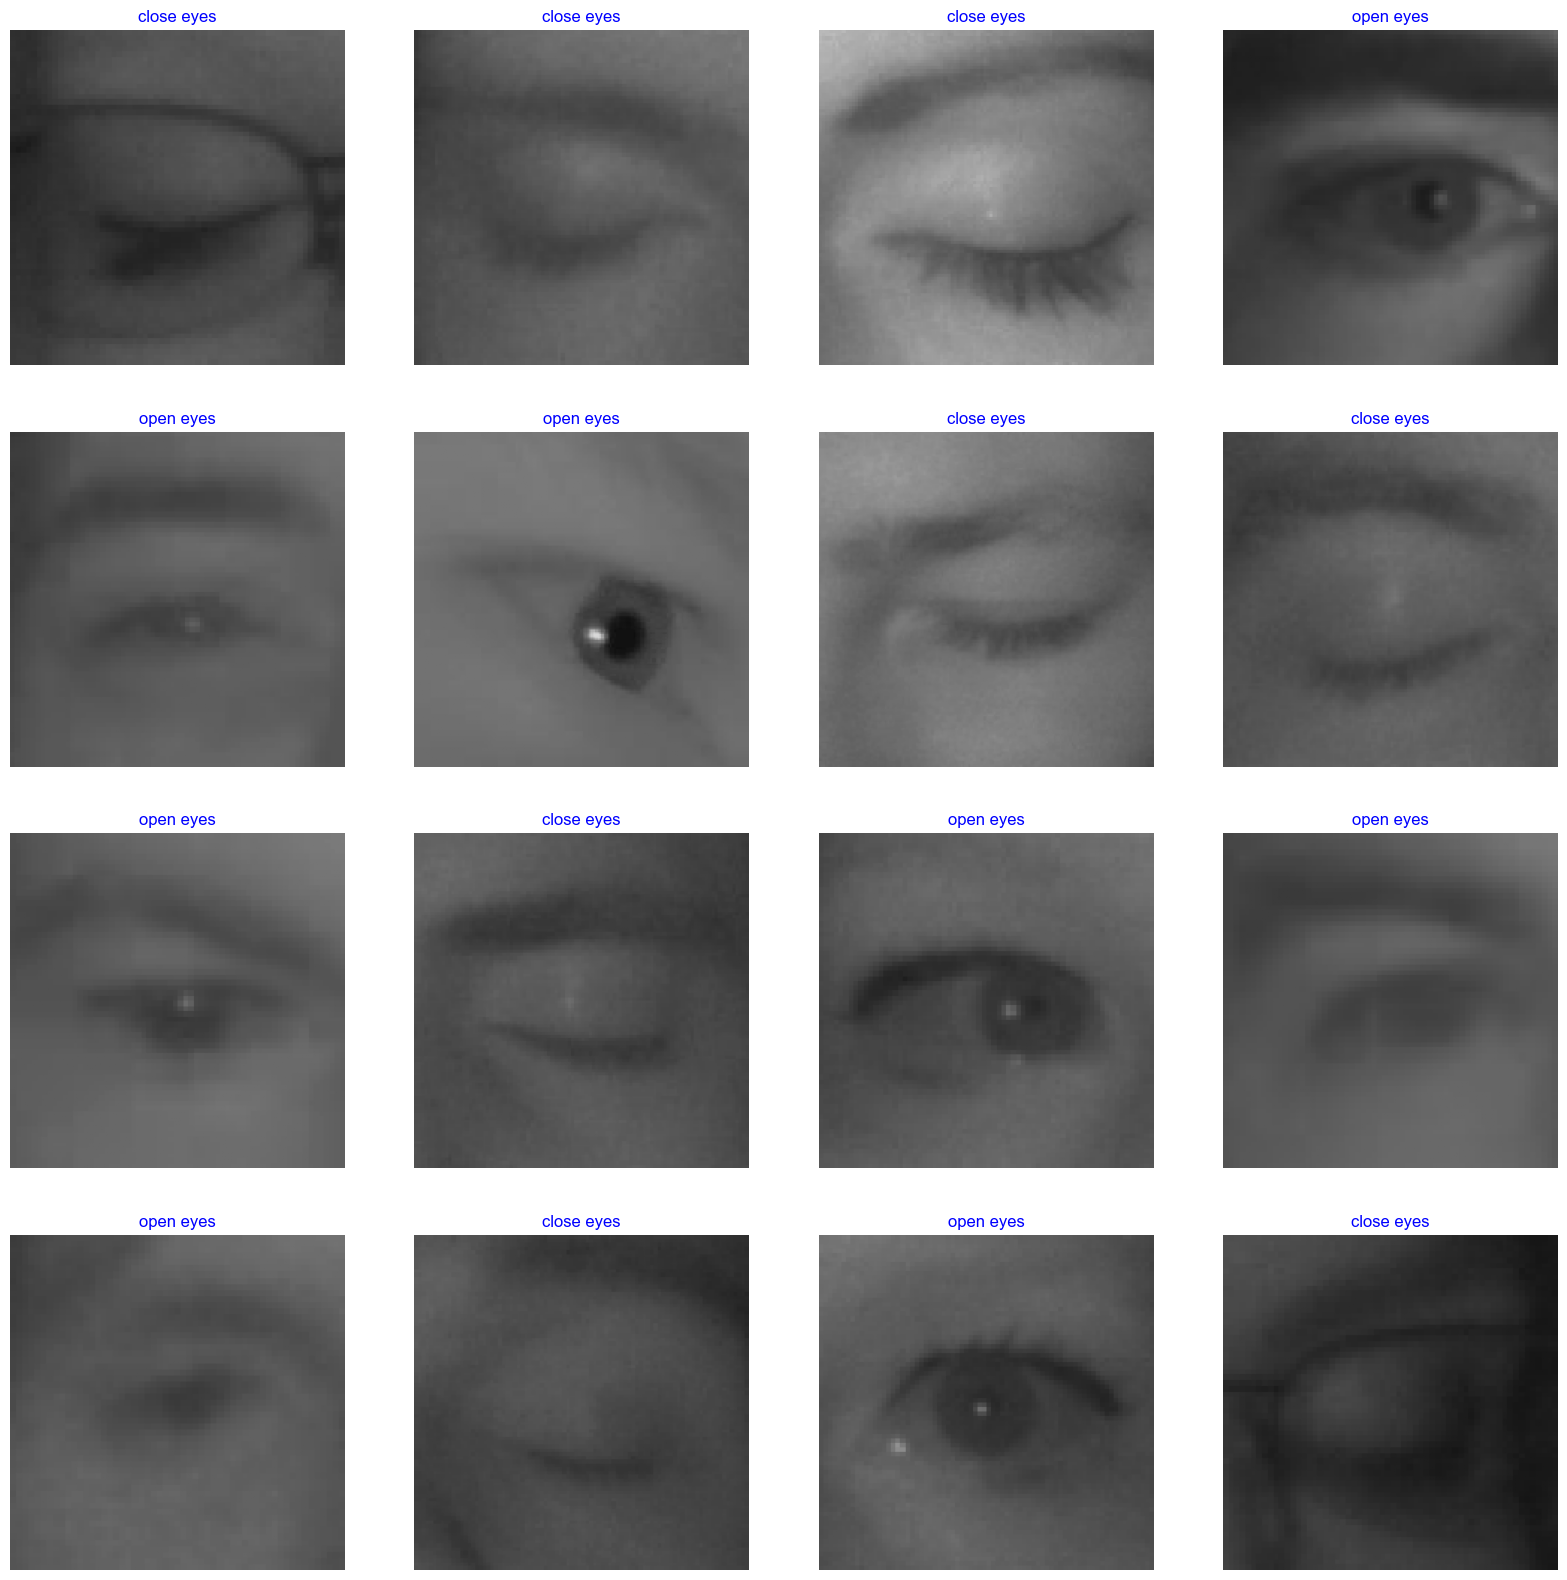

In [13]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

Model


In [15]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,141 (16.72 MB)

 Trainable params: 4,338,558 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [16]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/10
4084/4084 ━━━━━━━━━━━━━━━━━━━━ 2507s 611ms/step - accuracy: 0.5258 - loss: 3.5908 - val_accuracy: 0.5038 - val_loss: 0.6996
Epoch 2/10
4084/4084 ━━━━━━━━━━━━━━━━━━━━ 2485s 608ms/step - accuracy: 0.5224 - loss: 0.6920 - val_accuracy: 0.9846 - val_loss: 0.3642
Epoch 3/10
4084/4084 ━━━━━━━━━━━━━━━━━━━━ 2487s 609ms/step - accuracy: 0.8821 - loss: 0.4216 - val_accuracy: 0.9906 - val_loss: 0.2334
Epoch 4/10
4084/4084 ━━━━━━━━━━━━━━━━━━━━ 2485s 609ms/step - accuracy: 0.8873 - loss: 0.3461 - val_accuracy: 0.9881 - val_loss: 0.1874
Epoch 5/10
4084/4084 ━━━━━━━━━━━━━━━━━━━━ 2483s 608ms/step - accuracy: 0.8875 - loss: 0.3249 - val_accuracy: 0.9852 - val_loss: 0.1682
Epoch 6/10
4084/4084 ━━━━━━━━━━━━━━━━━━━━ 2492s 610ms/step - accuracy: 0.8874 - loss: 0.3140 - val_accuracy: 0.9751 - val_loss: 0.1634
Epoch 7/10
4084/4084 ━━━━━━━━━━━━━━━━━━━━ 2481s 607ms/step - accuracy: 0.8906 - loss: 0.3030 - val_accuracy: 0.9828 - val_loss: 0.1698
Epoch 8/10
4084/4084 ━━━━━━━━━━━━━━━━━━━━ 2483s 608ms/s

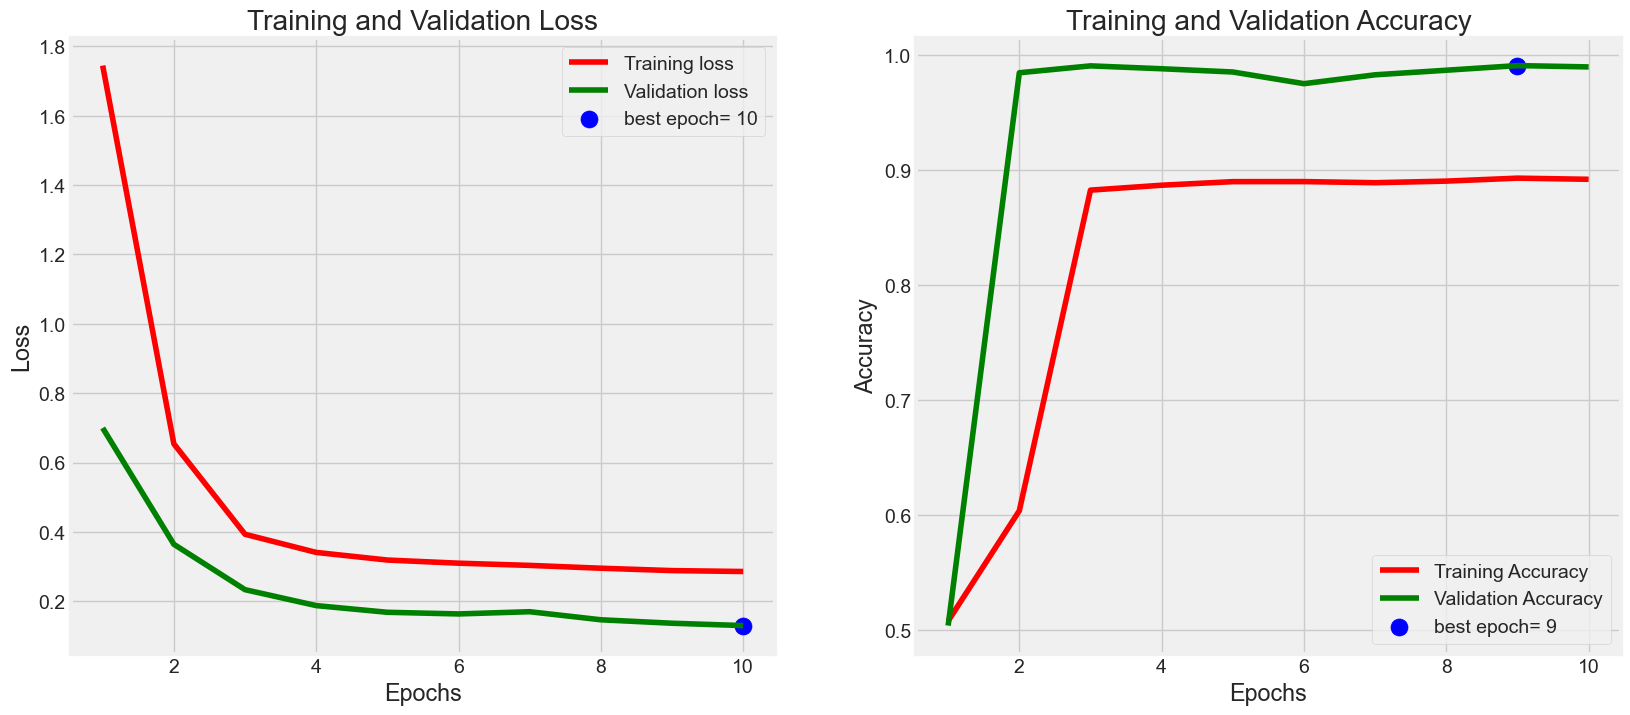

In [23]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Evaluate

In [18]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

293/293 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.9941 - loss: 0.1226
293/293 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.9932 - loss: 0.1232
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.8782 - loss: 0.2980
Train Loss:  0.12313292175531387
Train Accuracy:  0.9942406415939331
--------------------
Validation Loss:  0.1287526786327362
Validation Accuracy:  0.990401029586792
--------------------
Test Loss:  0.21653421223163605
Test Accuracy:  0.9298790097236633


Prediction

In [21]:
preds = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(preds, axis=1)

293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step


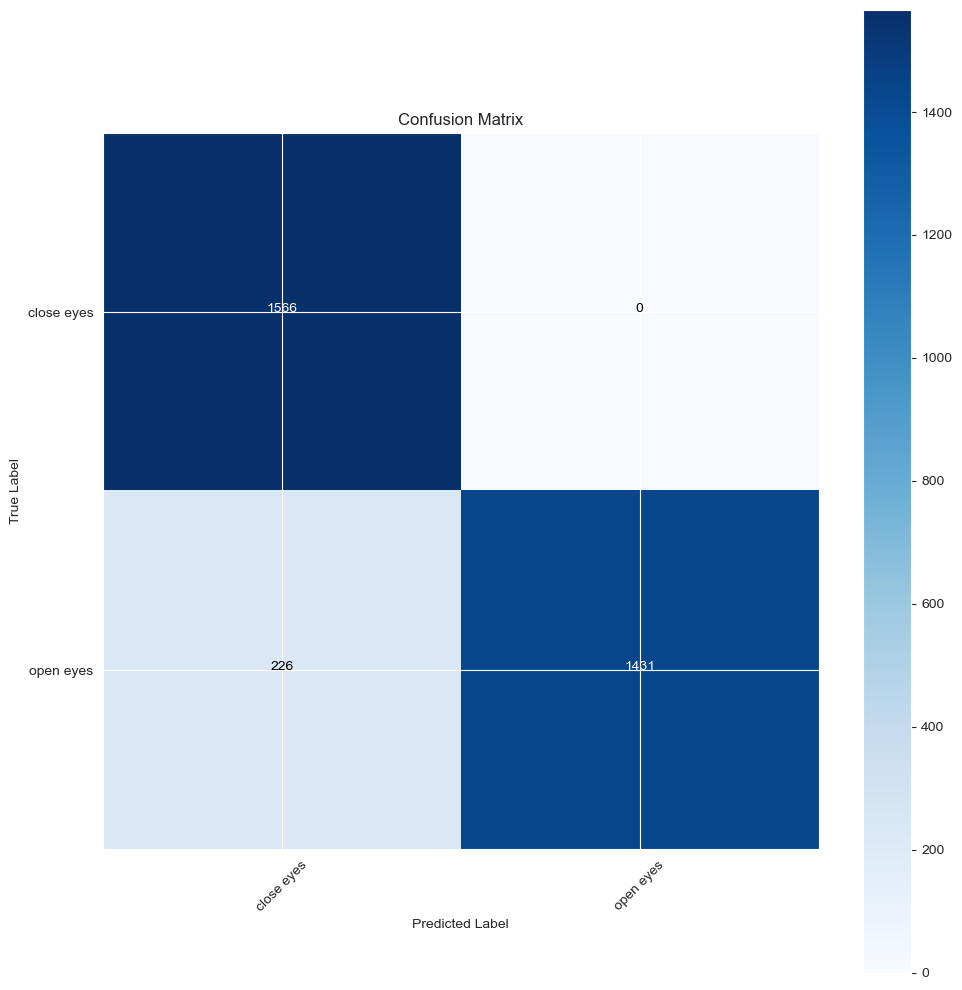

In [22]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [24]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

  close eyes       0.87      1.00      0.93      1566
   open eyes       1.00      0.86      0.93      1657

    accuracy                           0.93      3223
   macro avg       0.94      0.93      0.93      3223
weighted avg       0.94      0.93      0.93      3223



In [41]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
# 设置参数
img_size = (224, 224)
img_paths = ['test new data/open1.jpeg', 'test new data/open2.jpeg', 'test new data/close1.jpeg', 'test new data/close2.jpeg']

# 获取类别索引映射（例如 {'close eyes': 0, 'open eyes': 1}）
class_indices = train_gen.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# 单张预测函数
def predict_single_image(model, img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)         # (1, 224, 224, 3)
    img_array = preprocess_input(img_array)                # 按EfficientNet标准处理

    pred = model.predict(img_array)
    pred_class_index = np.argmax(pred, axis=1)[0]
    class_name = index_to_class[pred_class_index]

    print(f"{img_path} → 预测类别: {class_name} (index={pred_class_index})")

# 对两个文件进行预测
for path in img_paths:
    predict_single_image(model, path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
test new data/open1.jpeg → 预测类别: close eyes (index=0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
test new data/open2.jpeg → 预测类别: close eyes (index=0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
test new data/close1.jpeg → 预测类别: close eyes (index=0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
test new data/close2.jpeg → 预测类别: close eyes (index=0)


In [42]:
model.save('model/model.h5')